In [1]:
# from craft_text_detector import Craft
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract
import scipy.cluster.hierarchy as hcluster

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest

In [118]:
# import craft functions
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)

class Craft():

    def __init__(self, cuda=False):
        
        self.cuda = cuda
        # load models
        self.refine_net = load_refinenet_model(cuda=self.cuda)
        self.craft_net = load_craftnet_model(cuda=self.cuda)

    def detect(self, image):
        h, w = image.shape[:2]  
        # CRAFT internally scales to % 32 - so easier if we scale first
        # rather than trying to align image and heatmap
        h, w = self._calculate_32x_height_width(h, w)
        resized_image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        # Set long size to max dim, otherwise CRAFT will scale
        long_size = max([h, w])

        prediction = get_prediction(
            image=resized_image,
            craft_net=self.craft_net,
            refine_net=self.refine_net,
            text_threshold=0.7,
            link_threshold=0.4,
            low_text=0.4,
            cuda=self.cuda,
            long_size=long_size
        )

        heatmap = prediction["heatmaps"]['text_score_heatmap']
        # Heatmap will always be 2x smaller
        resized_heatmap = cv2.resize(heatmap, (resized_image.shape[1], resized_image.shape[0]), interpolation=cv2.INTER_LINEAR)
        assert resized_heatmap.shape == resized_image.shape        
        prediction['image'] = resized_image
        prediction['resized_heatmap'] = resized_heatmap        
        return prediction

    @staticmethod
    def _scale_32x_dimension(d: int):
        # image height and width should be multiple of 32
        return round(d + (32 - (d % 32)))

    def _calculate_32x_height_width(self, h: int, w: int):
        shortest, longest = sorted([h, w])
        new_longest = self._scale_32x_dimension(longest)
        r = new_longest / longest
        new_shortest = self._scale_32x_dimension(r * shortest)
        return (new_longest, new_shortest) if h > w else (new_shortest, new_longest)   

In [119]:
craft = Craft(cuda=False)

In [124]:
images = [cv2.imread(f'ri434014-{i}.jpg') for i in range(4)]

images = [cv2.imread(f'norm-image-{i}.jpg') for i in range(4)]

# im = ['norm-image0.jpg']

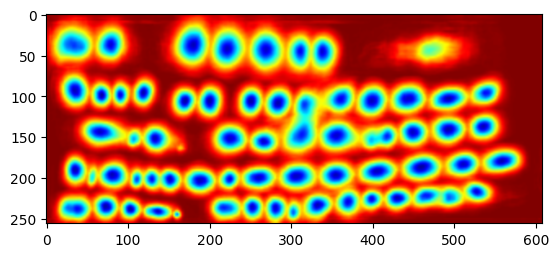

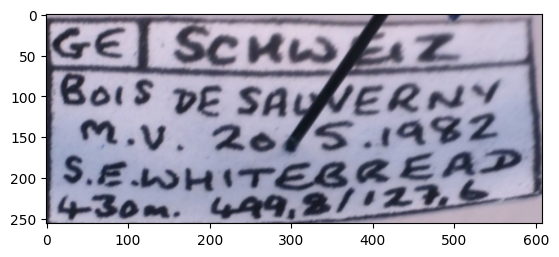

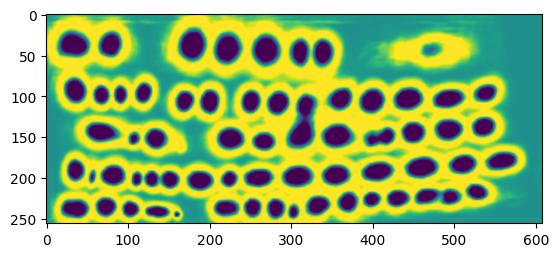

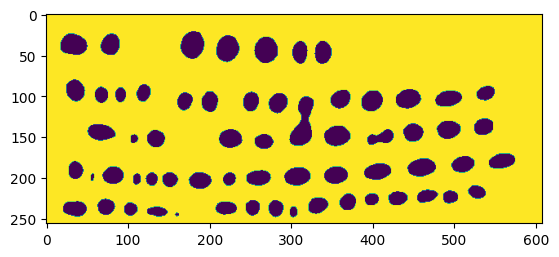

(<matplotlib.image.AxesImage at 0x15af41cc0>, None)

In [125]:
plt.imshow(prediction2['resized_heatmap']), plt.show()
plt.imshow(prediction2['image']), plt.show()

heatmap = prediction2['resized_heatmap']
b, g, r = cv2.split(heatmap)
plt.imshow(b), plt.show()

# Convert BGR image to HSV
hsv_image = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)

# Define the blue hue range
# lower_blue = np.array([120, 50, 50])
# upper_blue = np.array([150, 255, 255])

lower_blue = np.array([60, 50, 50])  # Lower hue value increased
upper_blue = np.array([0, 255, 255])  # Upper hue value decreased

# Create a mask for blue elements
blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
plt.imshow(blue_mask), plt.show()

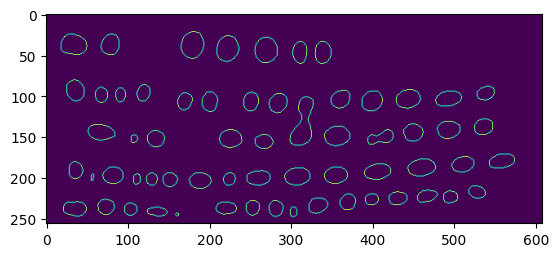

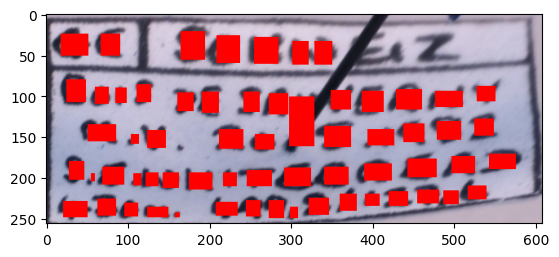

(<matplotlib.image.AxesImage at 0x15b1efa00>, None)

In [149]:
vis = prediction2['image'].copy()

inverted_mask = 255 - blue_mask
contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rects = []        

contour_image = np.zeros_like(blue_mask)
cv2.drawContours(contour_image, contours, -1, (255), 1) 
plt.imshow(contour_image), plt.show()

# Filter out smaller contours
min_area = 4
contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    # Remove any boxes along the top/bottom edges - overlapping from other rows
    # if y == 0 or (y + h) >= self.height: continue            
    rects.append([(x, y), (x + w, y + h)])   

# cv2.drawContours(vis, contours, -1, (0, 255, 0), 2)  # -1 to draw all contours, (0, 255, 0) for green color, 2 for line thickness


for pt1, pt2 in rects:
    cv2.rectangle(vis, pt1, pt2, 255, -1)

plt.imshow(vis), plt.show()

608
256


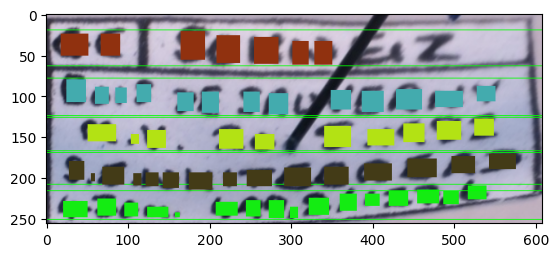

(<matplotlib.image.AxesImage at 0x15956c0a0>, None)

In [176]:
from scipy.stats import zscore

vis = prediction2['image'].copy()
rects = np.array(rects)
baselines = np.array([max(y) for y in rects[:,:, 1]])
    
cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), t=5, criterion="maxclust")

thresh = 10
cluster_labels = hcluster.fclusterdata(baselines.reshape(-1,1), thresh, criterion="distance")

# TODO - Validate all labels have the same number of clusters
num_clusters = len(np.unique(cluster_labels))

colors = {l:random_colour() for l in np.unique(cluster_labels)}

clusters = {}
for label, rect in zip(cluster_labels, rects):
    clusters.setdefault(label, []).append(rect)

for label, cluster in clusters.items():
    cluster = np.array(cluster)
    rectangle_heights = np.abs(np.diff(cluster[:,:,1]))
    z_scores = np.abs(zscore(rectangle_heights))

    
# Define a threshold for outlier detection (e.g., z-score > 2)


def filter_outliers(rects, threshold = 3):
    """
    Filter any outlier rects by height (potentially joined up latters)
    """
    rects = np.array(rects)
    rectangle_heights = np.abs(np.diff(rects[:,:,1]))
    z_scores = np.abs(zscore(rectangle_heights))
    return rects[np.where(z_scores < threshold)[0]]
    
clusters = {label: filter_outliers(cluster) for label, cluster in clusters.items()}

h, w = vis.shape[:2]

print(w)
print(h)




for label, cluster in clusters.items():

    ymin, ymax = minmax(cluster[:,:,1])
    box = np.array([(0, ymin), (w, ymax)])


    
    pt1, pt2 = box
    cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 1)

    for i, rect in enumerate(cluster):

        color = colors[label]
        # print(rect)

        pt1, pt2 = rect
        cv2.rectangle(vis, pt1, pt2, color, -1)

plt.imshow(vis), plt.show()    



# print(colors)


# cluster_labels



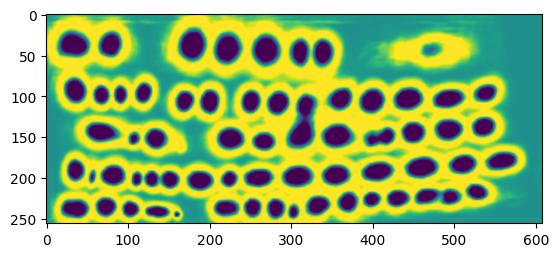

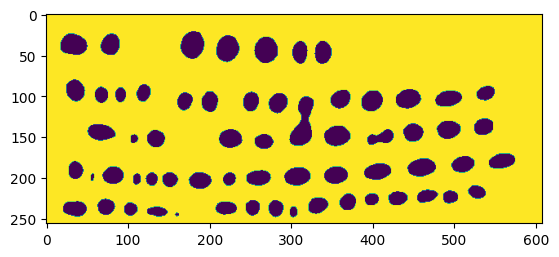

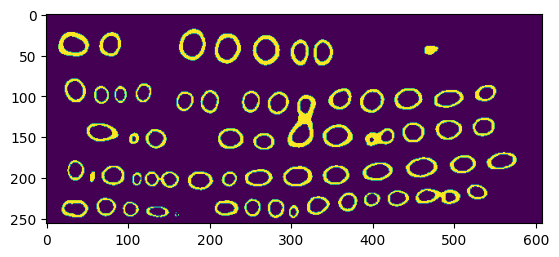

(<matplotlib.image.AxesImage at 0x15b510c40>, None)

In [180]:
heatmap = prediction2['resized_heatmap']
b, g, r = cv2.split(heatmap)
plt.imshow(b), plt.show()

# Convert BGR image to HSV
hsv_image = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)

# Define the blue hue range
lower_blue = np.array([40, 50, 50])  # Lower hue value increased
upper_blue = np.array([220, 255, 255])  # Upper hue value decreased


# Create a mask for blue elements
blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
plt.imshow(blue_mask), plt.show()

heatmap = np.array(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY))

# Define the threshold value - values above this will be hotspots to draw boxes around
threshold = 200    
# Create a binary mask
binary_mask = heatmap > threshold

plt.imshow(binary_mask), plt.show()

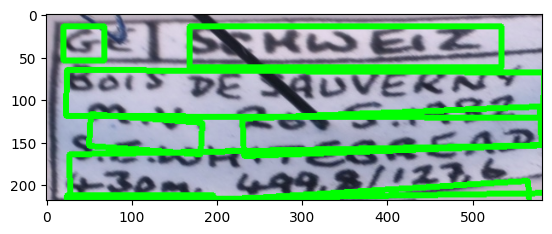

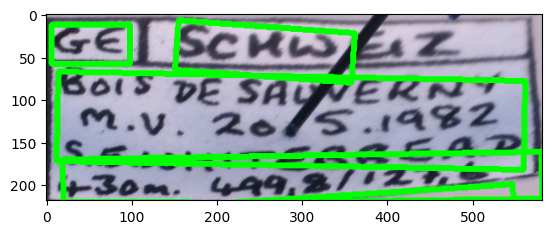

(<matplotlib.image.AxesImage at 0x1578ebc10>, None)

In [55]:

img = image1.copy()

for box in prediction1['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img, [points], True, (0,255,0), 5) 

plt.imshow(img), plt.show()

img2 = image2.copy()

for box in prediction2['boxes']:
    points = box.astype(int).reshape((-1, 1, 2))
    cv2.polylines(img2, [points], True, (0,255,0), 5) 

plt.imshow(img2), plt.show()

# img = image1.copy()

# for box in prediction1['boxes']:
#     points = box.astype(int).reshape((-1, 1, 2))
#     # (x1, y1), (x2, y2), (x3, y3), (x4, y4) = box.astype(int).T

#     output_width = 200
#     output_height = 300
    
#     # Define the destination points for the output rectangle
#     output_points = np.array([[0, 0], [output_width, 0], [output_width, output_height], [0, output_height]], dtype=np.float32)

#     M = cv2.getPerspectiveTransform(points, output_points)

#     # Apply the perspective transformation to the image
#     warped_image = cv2.warpPerspective(img, M, (20, 70))

#     cv2.polylines(img, [points], True, (0,255,0), 5) 
#     break

# plt.imshow(warped_image), plt.show()

In [48]:
# UTILS

from random import randrange

def minmax(arr: np.array):
    return np.min(arr), np.max(arr)
    
def is_range_intersect(range1, range2):
    return  pd.Interval(*minmax(range1), closed='both').overlaps(pd.Interval(*minmax(range1), closed='both')) 

def random_colour():
    return (randrange(255), randrange(255), randrange(255))

/var/folders/qc/qfn2fhqj089dgly0lzbhrjrr0000gp/T/ipykernel_30996/3147447289.py:87: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


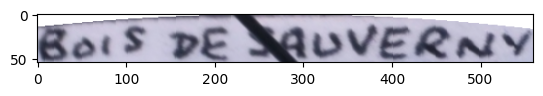

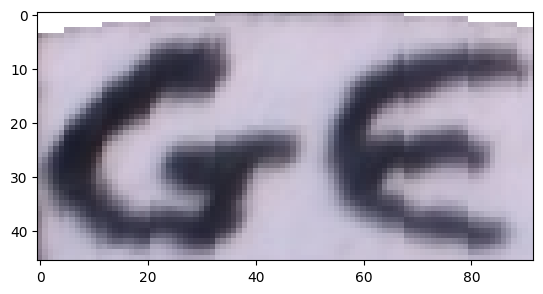

In [49]:
# def extract_text_area(poly, image):
#     # Four corners
#     a,b,c,d = poly.astype(int)
#     # Boxes are quadrilaterals, so we can get width/height from edge lengths
#     width = max([
#         abs(b[0] - a[0]), 
#         abs(c[0] - d[0])
#     ])
#     height = max([
#         abs(a[1] - d[1]), 
#         abs(b[1] - c[1])
#     ])  
#     dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
#     M = cv2.getPerspectiveTransform(box, dst_pts)
#     return cv2.warpPerspective(image, M, (width, height))    

img = image1.copy()


from imutils.perspective import order_points

class TextBoundingBox():
    def __init__(self, box, image, heatmap):

        #  Order points from top left clockwise
        self.vertices = order_points(box)
        # Four corners
        a,b,c,d = self.vertices.astype(int)

        # Boxes are quadrilaterals, so we get width/height from edge lengths
        self.width = max([
            abs(b[0] - a[0]), 
            abs(c[0] - d[0])
        ])
        self.height = max([
            abs(a[1] - d[1]), 
            abs(b[1] - c[1])
        ])

        # Transform perspective so we're looking at the line of text straight on
        M = self._get_transformation_matrix()

        self.image = self.warp_perspective(image, M)
        self.heatmap = self.warp_perspective(heatmap, M)

    def _get_transformation_matrix(self):
        dst_pts = np.array([[0, 0], [self.width, 0], [self.width, self.height], [0, self.height]], dtype=np.float32)  
        return cv2.getPerspectiveTransform(self.vertices, dst_pts)         

    def warp_perspective(self, image, M):
        return cv2.warpPerspective(image, M, (self.width, self.height))

    def heatmap_rectangles(self):
        """
        Draw rectangles around points of heatmap density (representing letters)   
        """
    
        heatmap = np.array(cv2.cvtColor(self.heatmap, cv2.COLOR_BGR2GRAY))
    
        # Define the threshold value - values above this will be hotspots to draw boxes around
        threshold = 200    
        # Create a binary mask
        binary_mask = heatmap > threshold    
        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
        rects = []        

        # Filter out smaller contours
        min_area = 4
        contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Remove any boxes along the top/bottom edges - overlapping from other rows
            if y == 0 or (y + h) >= self.height: continue            
            rects.append([(x, y), (x + w, y + h)])   
            
        return np.array(rects)        

    def get_line_best_fit(self):
        # Fit a polynomial of degree 2 (quadratic)
        degree = 2    
        rects = self.heatmap_rectangles()
        baseline_centroids = np.array([
            (np.mean(rect[:, 0], dtype=np.int32), max(rect[:, 1])) for rect in rects
        ])   
        x, y = baseline_centroids.T
        coefficients = np.polyfit(x, y, degree) 
        return np.poly1d(coefficients)

    def visualise(self):
        image = self.image.copy()
        poly = self.get_line_best_fit()
        xs = np.linspace(0, self.width -1, self.width)
        y_hat = poly(xs)
        for x, y in zip(xs.astype(int),y_hat.astype(int)):
            image[y, x] = [255, 0, 0]            
        
        return image

    def warp(self):
        poly = self.get_line_best_fit()
        x = np.linspace(0, self.width-1, self.width)        
        y_hat = poly(x)   
        # Offset is the predicted y values minus the maximum  
        y_offsets = max(y_hat) - y_hat
        warped = self.image.copy()
        channels = warped.shape[2]
        # Roll down pixels by the offset from the line of best fit
        for i, y_offset in enumerate(y_offsets):
            y = round(y_offset)
            for c in range(channels):
                warped[:, i, c] = np.roll(warped[:, i, c], y)
            warped[:y, i, :] = 255
        return warped

          
# TOMORROW: Ignore this, just have it as a cell.
class TextRegions():

    # craft = Craft()

    # def __init__(image):
    #     # prediction = self.craft.detect(image)
    #     pass

    def __init__(self, prediction):
        self.prediction = prediction
        self.boxes = self._get_text_line_bounding_boxes()    
        
    def _get_text_line_bounding_boxes(self):
        boxes = self._merge_boxes_into_lines(self.prediction['boxes'])
        return [TextBoundingBox(box, self.prediction['image'].copy(), self.prediction['resized_heatmap'].copy()) for box in boxes]

    def _merge_boxes_into_lines(self, boxes):
        """
        Get lines of text boxes, merging boxes if they are single lines of text
        """
        sorted_boxes = sorted(boxes, key=lambda box: np.min(box[:,1]))
        # Create list with the first box
        groups = [[sorted_boxes[0]]]
        
        for box in sorted_boxes[1:]:
            prev = groups[-1][-1]
            # Does the poly fit on the same line as the previous one?
            # And has intersection on the y axis
            if np.min(box[:, 0]) > np.max(prev[:, 0]) and is_range_intersect(box[:, 1], prev[:, 1]):
                groups[-1].append(box)
            else:            
                groups.append([box]) 

        return [self._merge_group(group) for group in groups]    

    @staticmethod
    def _merge_group(group):
        # If we have more than one box in the group, merge all vertices and find min area rect
        if len(group) > 1:
            combined_vertices = np.concatenate(group)
            # Find the convex hull of the combined vertices
            convex_hull = cv2.convexHull(combined_vertices)        
            # Fit a rotated rectangle around the convex hull
            rect = cv2.minAreaRect(convex_hull)
            return cv2.boxPoints(rect)
        else:
            return group[0]   

    def visualise(self):  
        image = self.prediction['image'].copy()
        for bbox in self.boxes:
            cv2.polylines(image, [bbox.vertices.astype(int)], True, random_colour(), 2) 
        return image
        
    def __iter__(self):
        yield from self.boxes

    def __len__(self):
        return len(self.boxes)

    def __getitem__(self, i):
        return self.boxes[i]




regions1 = TextRegions(prediction1)
regions2 = TextRegions(prediction2)

label_index = 1

image1 = regions1[label_index].warp()
image2 = regions2[label_index].warp()
# print()
# regions2[label_index].warp()

# vis = regions.visualise()

plt.imshow(image1, 'gray')
plt.show()

plt.imshow(image2, 'gray')
plt.show()

# for region in regions2:
#     plt.imshow(region.warp(), 'gray')
#     plt.show()    
    
    
#     vis = region.image.copy()
#     rects = region.heatmap_rectangles()

#     for rect in rects:
#         pt1, pt2 = rect
#         cv2.rectangle(vis, pt1, pt2, (0, 255, 0), 2)

#     # print(r)
    
#     plt.imshow(region.heatmap, 'gray')
#     plt.show()
    



    

# # regions = TextLine(prediction2)
# # for region in regions:
# #     plt.imshow(region.image), plt.show()
# #     plt.imshow(region.heatmap), plt.show()
# #     # print(region)




# # def extract_text_areas(prediction):
# #     plt.imshow(prediction2['resized_heatmap']), plt.show()
# # plt.imshow(prediction2['image']), plt.show()
# #     image = prediction['image']
# #     for 
    

# # for box in prediction1['boxes']:
# #     text_box1 = extract_text_box(box, img)
# #     # break

    

# # img = image2.copy()
# # for box in prediction2['boxes']:
# #     text_box2 = extract_text_box(box, img)
# #     # break    


# # plt.imshow(text_box1), plt.show()
# # plt.imshow(text_box2), plt.show()


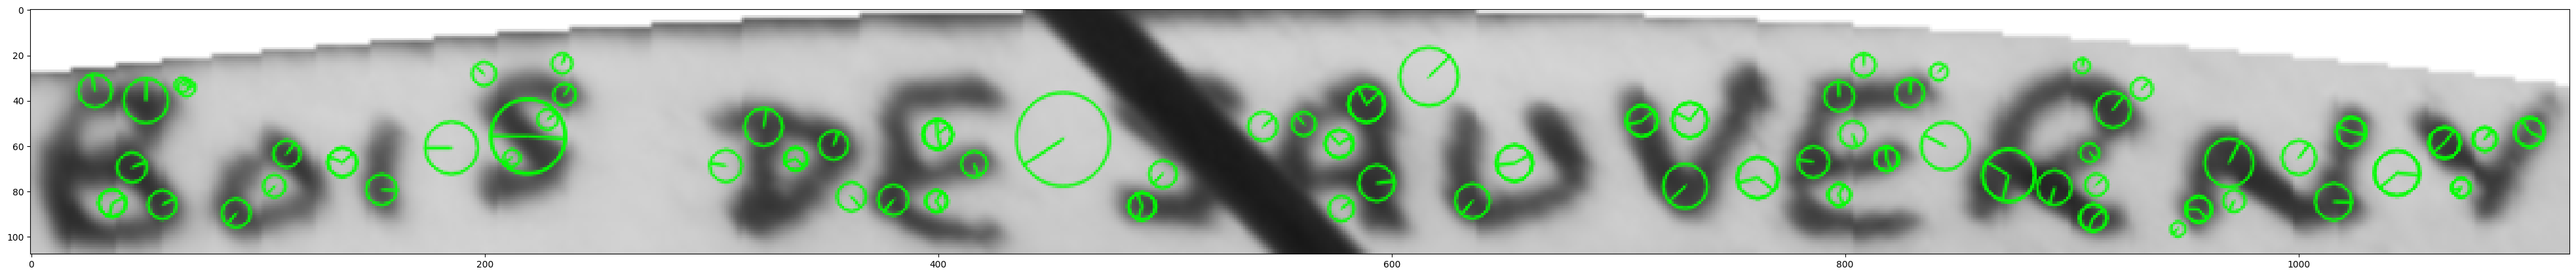

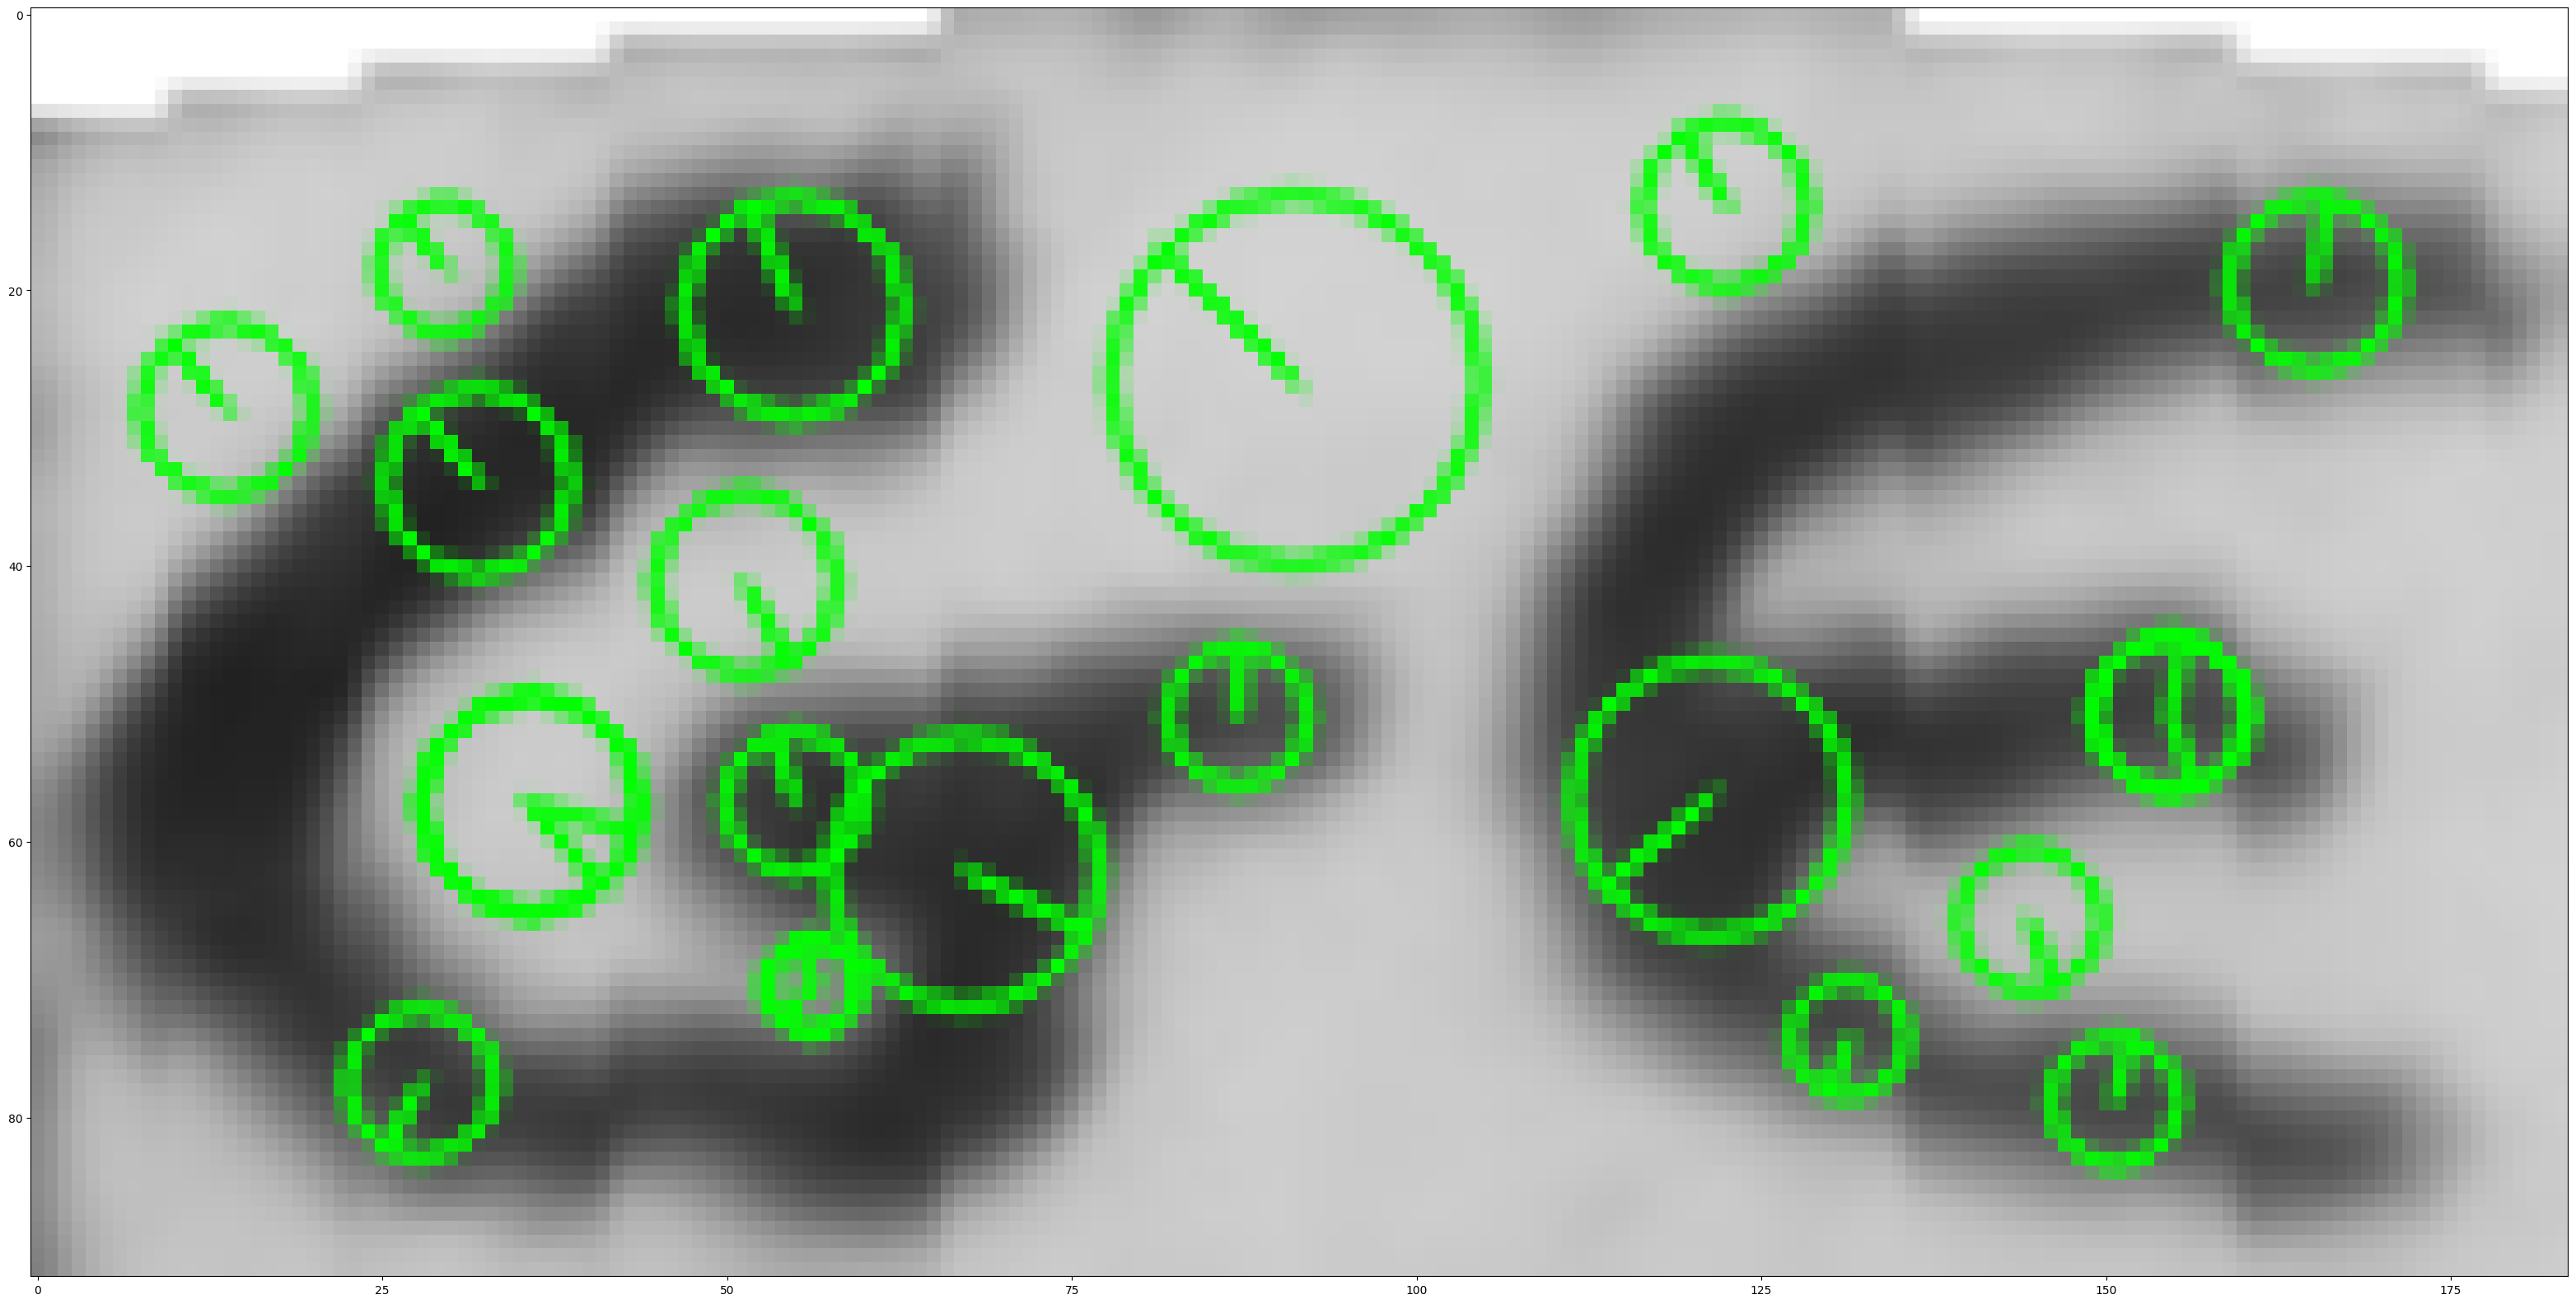

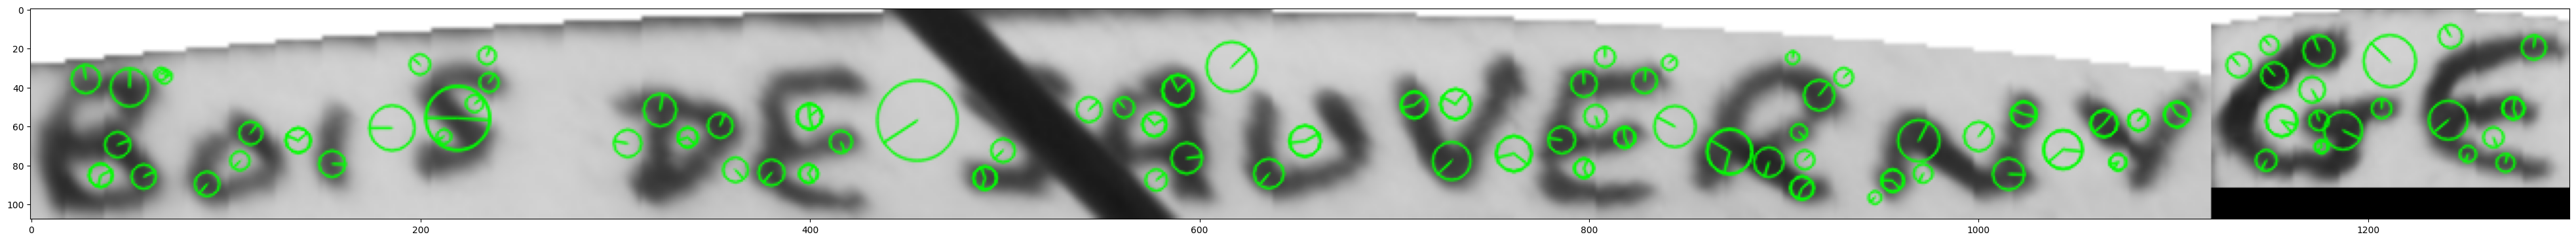

(<matplotlib.image.AxesImage at 0x15533caf0>, None)

In [50]:
def get_mask(image):
    threshold_value = 254
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(grey, threshold_value, 255, cv2.THRESH_BINARY)
    # Dilate the mask a little to exclude near keypoints
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=10)
    return cv2.bitwise_not(mask)

def threshold_image(image):

    mask = get_mask(image)
    cutoff_val = 200 # everything above this is set to the cutoff val
    set_color = 255 
    _, thresholded = cv2.threshold(image,cutoff_val,255,cv2.THRESH_TRUNC)
    window_size = 11
    grey_thresholded = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)

    grey_thresholded = cv2.bitwise_not(grey_thresholded)

    # masked = cv2.bitwise_and(grey_thresholded, mask)
    
    grey_thresholded = cv2.adaptiveThreshold(grey_thresholded, set_color, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,window_size,2)
    return grey_thresholded

    
    
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to remove small regions
    # cleaned_mask = cv2.erode(grey_thresholded, kernel, iterations=1)    
    return cleaned_mask
    # return cv2.bitwise_and(grey_thresholded, mask)

def threshold_image2(image):
    threshold_value = 120 
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(grey,threshold_value,255,cv2.THRESH_BINARY_INV)
    return threshold
    
def mask_keypoints(image, keypoints):
    threshold_value = 254
    # print(image.shape)
    # if image.shape[2] == 3:
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    # Dilate the mask a little to exclude near keypoints
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.bitwise_not(cv2.dilate(mask, kernel, iterations=10))
    # return mask

    # plt.imshow(mask), plt.show()

    return [kp for kp in keypoints if mask[int(kp.pt[1]), int(kp.pt[0])] > 0]
    
    # plt.imshow(mask),plt.show()

def resize_image(image, scale=2):
    h,w = image.shape[:2]
    return cv2.resize(image, (w * scale, h * scale), interpolation= cv2.INTER_LINEAR)

grey1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
grey2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

thresh1 = threshold_image2(image1.copy())
thresh2 = threshold_image2(image2.copy())

# plt.imshow(thresh1), plt.show()

# img1 = grey1.copy()
# img2 = grey2.copy()

img1 = thresh1.copy()
img2 = thresh2.copy()

img1 = grey1.copy()
img2 = grey2.copy()

img1 = resize_image(img1)
img2 = resize_image(img2)

# # Initiate ORB detector
# orb = cv2.ORB_create()
# # find the keypoints with ORB
# kp = orb.detect(img,None)
# # compute the descriptors with ORB
# kp, des = orb.compute(img, kp)
# # draw only keypoints location,not size and orientation
# img = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
# plt.figure(figsize = (50,20))
# plt.imshow(img), plt.show()



# corners = cv2.goodFeaturesToTrack(img,25,0.01,10)
# corners = np.int0(corners)
# for i in corners:
#     x,y = i.ravel()
#     cv2.circle(img,(x,y),3,255,-1)

# Initiate ORB detector
detector = cv2.ORB_create()
# find the keypoints and descriptors with ORB
# kp1, des1 = orb.detectAndCompute(img1,None)
# kp2, des2 = orb.detectAndCompute(img2,None)

detector = cv2.SIFT_create()




kp1 = detector.detect(img1)
kp2 = detector.detect(img2)

# # descriptor = cv2.xfeatures2d.DAISY_create()

# print(len(kp1))

kp1 = mask_keypoints(img1, kp1)
kp2 = mask_keypoints(img2, kp2)

# print(len(kp1))

img1 = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (50,20))
plt.imshow(img1), plt.show()

img2 = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (50,20))
plt.imshow(img2), plt.show()


descriptor = cv2.xfeatures2d.BEBLID_create(6.75)
# descriptor = cv.ORB_create()
kp1, des1 = detector.compute(img1, kp1)
kp2, des2 = detector.compute(img2, kp2)


# # create BFMatcher object
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# # # Match descriptors.
# matches = bf.knnMatch(des1,des2, k=2)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# matches = matches[:10]

good = []
for m in matches:
    point1 = np.array(kp1[m.queryIdx].pt)
    point2 = np.array(kp2[m.trainIdx].pt)
    # Calculate euclidean distance
    distance = np.linalg.norm(point2 - point1)
    # print(distance)
    if distance < 50:
        good.append(m)
        
    
    
    # print(distance)

# matches = bf.knnMatch(des1,des2,k=2)

# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])

# bf = cv2.BFMatcher()



# matches = good.copy()
    


# img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (50,20))
plt.imshow(img3),plt.show()


# print(type(kp1))

# filtered_kp1=tuple([kp1[m.queryIdx] for m in matches])
# filtered_kp2=tuple([kp2[m.trainIdx] for m in matches])

# print(filtered_kp1.size())



17


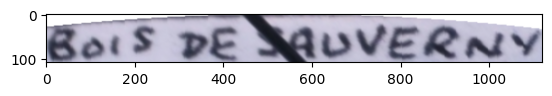

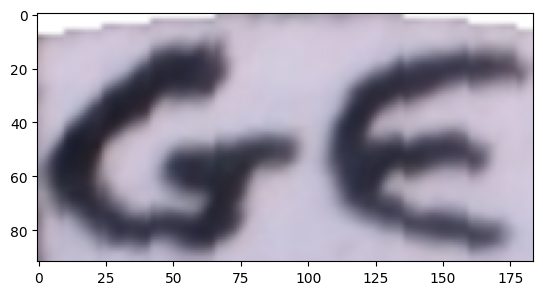

error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [51]:


# plt.imshow(img),plt.show()

print(len(matches))

# matches = matches[:10]

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

vis1 = resize_image(image1.copy())
vis2 = resize_image(image2.copy())

for i, point in enumerate(src_pts):
    color = random_colour()
    cv2.circle(vis1, point.astype('int').ravel(), 4, color, -1) 
    cv2.circle(vis2, dst_pts[i].astype('int').ravel(), 4, color, -1) 
    # break

plt.imshow(vis1, 'gray')
plt.show()

plt.imshow(vis2, 'gray')
plt.show()

# resize = image2.copy()
# for point in dst_pts:
#     cv2.circle(resize, point.astype('int').ravel(), 2, (0, 255, 0), -1)  # Green points, filled circles
#     # break
    
# plt.imshow(resize, 'gray')
# plt.show()

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# matchesMask = mask.ravel().tolist()

resized = resize_image(image1)

h,w = resized.shape[:2]

transformed_img = cv2.warpPerspective(resized, M, (w, h))
plt.imshow(transformed_img, 'gray')
plt.show()

alpha = 0.5
resized2 = resize_image(image2)
overlay_image = cv2.resize(transformed_img, (resized2.shape[1], resized2.shape[0]))

# image2.shape
# transformed_img.shape
overlay_result = cv2.addWeighted(resized2, 1 - alpha, overlay_image, alpha, 0)
plt.imshow(overlay_result, 'gray')
plt.show()


In [41]:
# ERRORS

source_points = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
destination_points = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Compute the homography
homography, _ = cv2.findHomography(source_points, destination_points, cv2.RANSAC)

# Transform the source points using the computed homography
transformed_points = cv2.perspectiveTransform(source_points.reshape(-1, 1, 2), homography)

# Calculate the reprojection error
reprojection_errors = np.linalg.norm(destination_points - transformed_points.squeeze(), axis=1)

np.mean(reprojection_errors)

871.1685

In [12]:

threshold_value = 120 
window_size = 15

def get_mask(image):
    threshold_value = 254
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(grey, threshold_value, 255, cv2.THRESH_BINARY)
    # Dilate the mask a little to exclude near keypoints
    kernel = np.ones((3, 3), np.uint8)
    # mask = cv2.dilate(mask, kernel, iterations=10)
    return cv2.bitwise_not(mask)

mask = get_mask(image1)





# grey_thresholded = cv2.adaptiveThreshold(grey, threshold_value, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,window_size,2)

masked = cv2.bitwise_and(grey_thresholded, mask)
plt.imshow(grey_thresholded),plt.show()

# window_size = 11
# grey_thresholded = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)

# grey_thresholded = cv2.bitwise_not(grey_thresholded)

NameError: name 'grey_thresholded' is not defined

In [ ]:
help(cv2.SIFT_create())

### Lets try feature detection again! 

In [ ]:
def threshold_image(image):

    cutoff_val = 200 # everything above this is set to the cutoff val
    set_color = 255 
    ret,thresh_img = cv2.threshold(image,cutoff_val,255,cv2.THRESH_TRUNC)
    window_size = 11
    thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(thresh_img,set_color,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,window_size,2)

def sift_detector(image1, image2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create(10000)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1,None)
    kp2, des2 = sift.detectAndCompute(image2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    # matches = matcher.knnMatch(des1, des2, 2)    
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append(m)

    return kp1, kp2, good 

def beblid(img1, img2):

    # detector = cv2.ORB_create(10000)
    detector = cv2.SIFT_create(10000)
    # akaze = cv2.AKAZE_create(threshold=0.001)
    
    # detector = cv2.ORB_create(10000)
    
    kpts1 = detector.detect(img1)
    kpts2 = detector.detect(img2)
    
    # # descriptor = cv.ORB_create()
    descriptor = cv2.xfeatures2d.DAISY_create()
    kpts1, desc1 = descriptor.compute(img1, kpts1)
    kpts2, desc2 = descriptor.compute(img2, kpts2)    

    
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    matches = matcher.knnMatch(desc1, desc2, 2)

    print(len(matches))
    
    good = []
    for m,n in matches:
        # print(m.distance)
        if m.distance < 0.9*n.distance:
            good.append(m)

    return kpts1, kpts2, good  

img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# img1 = threshold_image(image1.copy())
# img2 = threshold_image(image2.copy())

kp1, kp2, good = beblid(img1, img2)

print(len(good))

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h,w = image1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# # transformed_img = cv2.warpPerspective(image1, homography, (width, height))

transformed_img = cv2.warpPerspective(image1, M, (w, h))


# # img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# # print(good)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

vis = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)

plt.figure(figsize = (50,20))
plt.imshow(vis)
plt.show()

# plt.figure(figsize = (50,20))
plt.imshow(transformed_img, 'gray')
plt.show()


In [ ]:
alpha = 0.5

overlay_image = cv2.resize(transformed_img, (image2.shape[1], image2.shape[0]))

# image2.shape
# transformed_img.shape
overlay_result = cv2.addWeighted(image2, 1 - alpha, overlay_image, alpha, 0)
plt.imshow(overlay_result, 'gray')
plt.show()

In [ ]:
!pip install opencv-contrib-python

In [ ]:
import cv2.xfeatures2d

In [ ]:
!pip install opencv-contrib-python

In [ ]:
prediction1 = craft.detect(image1)
prediction2 = craft.detect(image2)

In [ ]:
prediction1.resize_heatmap